Found 5232 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/3
327/327 ━━━━━━━━━━━━━━━━━━━━ 627s 2s/step - accuracy: 0.8636 - loss: 0.2948 - val_accuracy: 0.8173 - val_loss: 0.4379
Epoch 2/3
327/327 ━━━━━━━━━━━━━━━━━━━━ 552s 2s/step - accuracy: 0.9566 - loss: 0.1115 - val_accuracy: 0.8093 - val_loss: 0.5114
Epoch 3/3
327/327 ━━━━━━━━━━━━━━━━━━━━ 548s 2s/step - accuracy: 0.9645 - loss: 0.0958 - val_accuracy: 0.7772 - val_loss: 0.6708


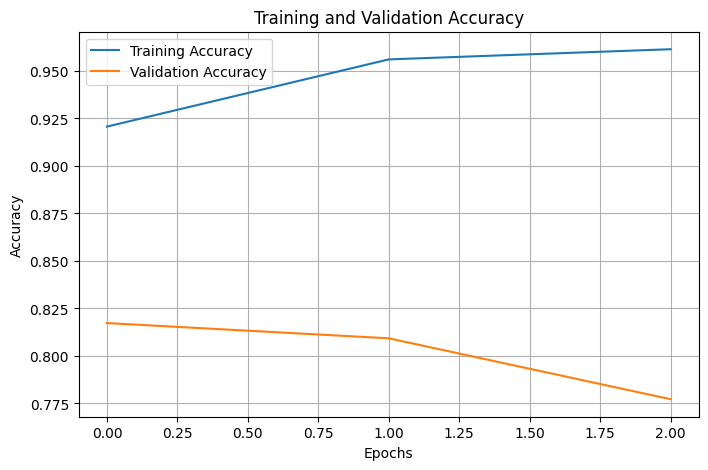

39/39 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.41      0.58       234
           1       0.74      1.00      0.85       390

    accuracy                           0.78       624
   macro avg       0.86      0.70      0.71       624
weighted avg       0.83      0.78      0.75       624

Confusion Matrix:
 [[ 96 138]
 [  1 389]]


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
import pathlib

# 1. Load dataset with manual path support for extracted data

def load_covid_xray_data(img_size=160, batch_size=16):
    # Path assuming dataset already manually downloaded & extracted in Colab files
    base_dir = "/content/chest_xray_dataset/chest_xray"
    train_dir = os.path.join(base_dir, "train")
    val_dir = os.path.join(base_dir, "test")  # Use test as validation due to available structure

    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir,
        image_size=(img_size, img_size),
        batch_size=batch_size,
        label_mode='int')

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        val_dir,
        image_size=(img_size, img_size),
        batch_size=batch_size,
        label_mode='int')

    class_names = train_ds.class_names

    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    return train_ds, val_ds, class_names

# 2. Build and fine-tune MobileNetV2

def build_mobilenet_model(num_classes, img_size=160):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(img_size, img_size, 3),
        include_top=False,
        weights='imagenet',
        pooling='avg')
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(img_size, img_size, 3))
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# 3. Train the model

def train_model():
    img_size = 160
    batch_size = 16
    train_ds, val_ds, class_names = load_covid_xray_data(img_size, batch_size)

    model = build_mobilenet_model(num_classes=len(class_names), img_size=img_size)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_ds, epochs=3, validation_data=val_ds)
    return history, model, val_ds

# 4. Plot accuracy

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# 5. Optional: Add evaluation report
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def evaluate_model(model, val_ds):
    true_labels = np.concatenate([y.numpy() for x, y in val_ds], axis=0)
    predictions = model.predict(val_ds)
    predicted_labels = np.argmax(predictions, axis=1)

    print("\nClassification Report:\n", classification_report(true_labels, predicted_labels))
    print("Confusion Matrix:\n", confusion_matrix(true_labels, predicted_labels))

# Main
if __name__ == '__main__':
    history, model, val_ds = train_model()
    plot_history(history)
    evaluate_model(model, val_ds)

# Notes:
# - Dataset must be manually extracted to `/content/chest_xray_dataset/chest_xray` in Colab.
# - Uses `test` folder as validation set since `val` is missing.
# - Added evaluation report to enable paper comparison.
# - Keeps MobileNetV2 lightweight and fast.
